In [11]:
# ============================
# 1. LOAD THE DATASET
# ============================

import pandas as pd

df = pd.read_csv("Dataset-Brief 1 Cyber.csv")

print(df.shape)
df.head()


(21185, 84)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,175.45.176.3-149.171.126.19-60976-8022-6,175.45.176.3,60976,149.171.126.19,8022,6,22/01/2015 08:28:40 AM,234286,7,5,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Generic
1,175.45.176.2-149.171.126.18-5975-80-6,175.45.176.2,5975,149.171.126.18,80,6,18/02/2015 03:58:40 AM,5337881,63,371,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Exploits
2,175.45.176.2-149.171.126.15-4770-80-6,175.45.176.2,4770,149.171.126.15,80,6,18/02/2015 08:08:41 AM,557632,7,7,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Exploits
3,175.45.176.3-149.171.126.14-6151-80-6,175.45.176.3,6151,149.171.126.14,80,6,22/01/2015 07:59:44 AM,1287210,7,7,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
4,59.166.0.1-149.171.126.0-12897-5190-6,59.166.0.1,12897,149.171.126.0,5190,6,22/01/2015 03:19:03 PM,342,1,2,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [12]:
# ============================
# 2. REMOVE USELESS COLUMNS
# ============================

df_clean = df.drop(columns=['Flow ID', 'Src IP', 'Dst IP', 'Timestamp'])

labels_original = df_clean['Label']
features = df_clean.drop(columns=['Label'])

zero_cols = features.columns[(features == 0).all()]
print("Columns that contain only zeros:", list(zero_cols))

features = features.drop(columns=zero_cols)

print("Shape after removing useless columns:", features.shape)


Columns that contain only zeros: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg']
Shape after removing useless columns: (21185, 70)


In [13]:
# ============================
# 3. GROUP LABELS INTO 3 CLASSES
# ============================

def group_label(lbl):
    # 1️⃣ Normal Traffic
    if lbl in ['Benign', 'Analysis']:
        return 'Normal'

    # 2️⃣ Network Attacks (traffic-based attacks)
    elif lbl in ['DoS', 'Exploits', 'Generic', 'Fuzzers', 'Reconnaissance']:
        return 'Network Attacks'

    # 3️⃣ Malware / Code-based Attacks
    elif lbl in ['Backdoor', 'Shellcode', 'Worms']:
        return 'Malware CodeAttacks'

    # Backup (if any unknown label appears)
    else:
        return 'Unknown'

df_clean['MainLabel'] = df_clean['Label'].map(group_label)

print(df_clean['MainLabel'].value_counts())


MainLabel
Network Attacks        15000
Normal                  3385
Malware CodeAttacks     2800
Name: count, dtype: int64


In [14]:
# ============================
# 4. LABEL ENCODING + TRAIN/TEST SPLIT
# ============================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = features                      # numeric features
y_str = df_clean['MainLabel']     # string labels (Normal / Network_Attacks / Malware_CodeAttacks)

# Encode labels to integers 0,1,2
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_str)

print("Class mapping:")
for idx, name in enumerate(label_encoder.classes_):
    print(idx, "=", name)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Class mapping:
0 = Malware CodeAttacks
1 = Network Attacks
2 = Normal
Training shape: (14829, 70)
Testing shape: (6356, 70)
Training shape: (14829, 70)
Testing shape: (6356, 70)


In [15]:
# ============================
# 5. FEATURE SCALING
# ============================

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [16]:
# ============================
# 6. TRAIN SVM MODEL
# ============================

from sklearn.svm import SVC

svm_rbf = SVC(
    kernel='rbf',
    C=5,
    gamma='scale',
    class_weight='balanced',
    random_state=42
)

svm_rbf.fit(X_train_scaled, y_train)

print("✔ SVM model trained successfully")


✔ SVM model trained successfully


In [17]:
# ============================
# 7. EVALUATE MODEL PERFORMANCE
# ============================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict encoded labels
y_pred = svm_rbf.predict(X_test_scaled)

# Decode back to original string labels
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

class_names = list(label_encoder.classes_)   # ['Malware_CodeAttacks','Network_Attacks','Normal'] (أو حسب الترتيب)

print("🔥 Accuracy:", round(accuracy_score(y_test_labels, y_pred_labels), 4))

print("\n📌 Classification Report:")
print(classification_report(
    y_test_labels,
    y_pred_labels,
    labels=class_names
))

print("\n📌 Confusion Matrix (raw):")
print(confusion_matrix(
    y_test_labels,
    y_pred_labels,
    labels=class_names
))


🔥 Accuracy: 0.9034

📌 Classification Report:
                     precision    recall  f1-score   support

Malware CodeAttacks       0.76      0.82      0.79       840
    Network Attacks       0.96      0.90      0.93      4500
             Normal       0.81      0.98      0.89      1016

           accuracy                           0.90      6356
          macro avg       0.84      0.90      0.87      6356
       weighted avg       0.91      0.90      0.90      6356


📌 Confusion Matrix (raw):
[[ 685  150    5]
 [ 210 4060  230]
 [   9   10  997]]


In [18]:
# ============================
# 8. CROSS VALIDATION (OPTIONAL)
# ============================

from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_rbf, X_train_scaled, y_train, cv=5)
print("Cross-Validation scores:", scores)
print("Mean CV accuracy:", scores.mean())


Cross-Validation scores: [0.90694538 0.8971679  0.90188806 0.90694538 0.89848229]
Mean CV accuracy: 0.9022858046050859


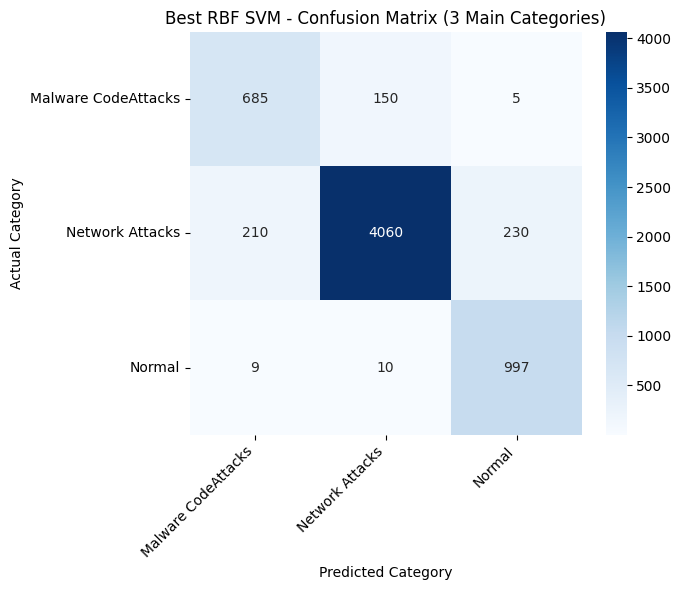

In [19]:
# ============================
# 9. CONFUSION MATRIX HEATMAP
# ============================

import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(
    y_test_labels,
    y_pred_labels,
    labels=class_names
)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Best RBF SVM - Confusion Matrix (3 Main Categories)")
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


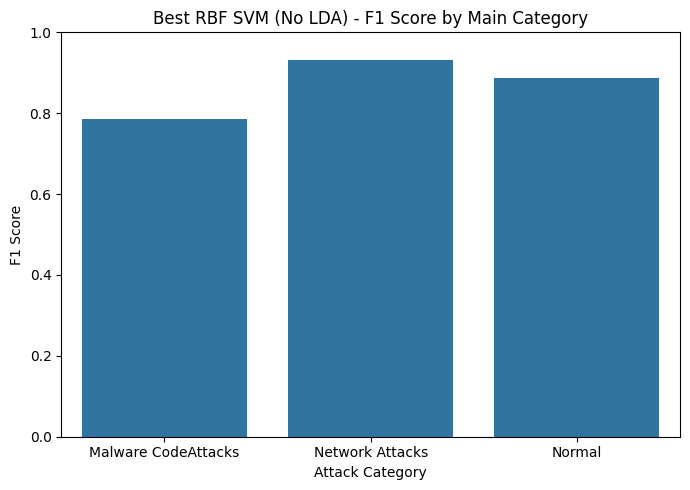

In [20]:
# ============================
# 10. F1-SCORE BAR CHART
# ============================

report = classification_report(
    y_test_labels,
    y_pred_labels,
    labels=class_names,
    output_dict=True
)

f1_scores = [report[label]['f1-score'] for label in class_names]

plt.figure(figsize=(7, 5))
sns.barplot(x=class_names, y=f1_scores)

plt.title("Best RBF SVM (No LDA) - F1 Score by Main Category")
plt.xlabel("Attack Category")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

